In [1]:
!pip install pygame pyvirtualdisplay

In [2]:
!apt install swig && pip install gymnasium box2d box2d-kengz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML
import base64
import os

In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
print(env.observation_space)
print(env.action_space)

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Discrete(2)


In [5]:
env.observation_space.shape

(4,)

In [6]:
obs_space_low_ar = env.observation_space.low
obs_space_high_ar = env.observation_space.high
arrays = []
for i in range(len(obs_space_low_ar)):
    arrays.append([obs_space_low_ar[i], obs_space_high_ar[i]])
obs_bounds = np.array(arrays)
print(obs_bounds)


[[-4.8         4.8       ]
 [       -inf         inf]
 [-0.41887903  0.41887903]
 [       -inf         inf]]


In [7]:
practical_state_bounds = np.array([[-4.8, 4.8], [-10, 10], [-0.41887903, 0.41887903], [-10, 10]])

In [8]:
import numpy as np

class TileCoder:
    def __init__(self, num_tilings, tiles_per_dim, state_bounds):
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim
        self.state_bounds = state_bounds  # shape: (D, 2), where D = state dimensions

        self.state_dim = len(state_bounds)
        self.tile_width = (self.state_bounds[:, 1] - self.state_bounds[:, 0]) / (tiles_per_dim - 1)
        self.offsets = [np.linspace(0, self.tile_width[d], num_tilings) for d in range(self.state_dim)]

        self.total_tiles = (tiles_per_dim ** self.state_dim) * num_tilings

    def get_features(self, state):
        """
        Return binary feature vector for given state only (not action)
        """
        features = np.zeros(self.total_tiles)
        for tiling in range(self.num_tilings):
            coords = []
            for i in range(self.state_dim):
                offset = self.offsets[i][tiling]
                coord = int((state[i] - self.state_bounds[i][0] + offset) / self.tile_width[i])
                coords.append(coord)

            flat_index = self._tile_index(tiling, coords)
            features[flat_index] = 1

        return features.reshape(-1)

    def _tile_index(self, tiling, coords):
        """
        Compute flattened index in the feature vector (no action)
        """
        index = 0
        for c in coords:
            index = index * self.tiles_per_dim + c
        index += tiling * (self.tiles_per_dim ** self.state_dim)
        return index
tile_coder = TileCoder(num_tilings=8, tiles_per_dim=8, state_bounds=practical_state_bounds)

In [12]:
from itertools import combinations_with_replacement

def polynomial_features(state, degree=1):
    """
    Generate a polynomial basis feature vector from a 4D state.

    Parameters:
        state: array-like
        degree: int, the maximum total degree of polynomial terms

    Returns:
        feature_vector: np.ndarray, shape (num_features,)
    """
    state = np.asarray(state)
    size = state.shape[0]

    # Create index tuples for all monomials up to the given degree
    feature_vector = [1.0]  # bias term
    for d in range(1, degree + 1):
        for idxs in combinations_with_replacement(range(size), d):
            term = 1.0
            for i in idxs:
                term *= state[i]
            feature_vector.append(term)

    return np.array(feature_vector).reshape(-1)


The action space is discrete with actions taking on values of 0 or 1 . The observation space is a continuous space in R^4. The second and fourth dimensions are unbounded but I will be clipping them.  This notebook is an implementation of the REINFORCE with Baseline algorithm. The baseline is a function approximatation of the state value using a linear function. The parameterized policy will be a Neural Network.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

alpha_sv_estimates = .05
alpha_policy_updates = .005
gamma = .99 #discount factor on future rewards
num_episodes = 50000
dim = polynomial_features(env.observation_space.sample()).shape[0]
wts = np.random.normal(size=dim)
num_actions = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, action_dim)


    def forward(self, state):
        x = F.relu(self.fc1(state))

        if torch.isnan(x).any():
          print(state)
          print(self.fc1(state))
          print("NaNs detected in output of layer 1!")

        if torch.isinf(x).any():
          print("Infs detected in output of layer 1!")

        logits = self.fc2(x)

        if torch.isnan(logits).any():
          print("NaNs detected in logits!")

        if torch.isinf(logits).any():
          print("Infs detected in logits!")

        probs = F.softmax(logits, dim=-1)
        return probs

def get_features(s):
  clipped_state = np.clip(s, practical_state_bounds[:, 0], practical_state_bounds[:, 1])
  return tile_coder.get_features(clipped_state)

def gradient_descent_sv_weights(w, G, s):
  features = polynomial_features(s)
  w += alpha_sv_estimates * (G - np.dot(w, features)) * features
  return w

def select_action(policy_net, state):
    features = polynomial_features(state)
    if np.isnan(features).any():
      print("NaNs in features!")
    input = torch.tensor(features, dtype=torch.float32).to(device)
    probs = policy_net(input)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    return action.item(), log_prob

def get_log_prob(s, a):
  features = polynomial_features(s)
  if np.isnan(features).any():
    print("NaNs in features!")
  input = torch.tensor(features, dtype=torch.float32)
  probs = policy_network(input)
  m = torch.distributions.Categorical(probs)
  log_prob = m.log_prob(torch.tensor(a, dtype=torch.long))
  return log_prob



In [14]:
policy_network = PolicyNetwork(dim, num_actions).to(device)
optimizer = torch.optim.Adam(policy_network.parameters(), lr=alpha_policy_updates)

for episode_idx in range(num_episodes):
    rewards = []
    actions = []
    states = []
    log_probs = []

    obs, _ = env.reset()
    undiscounted_reward_sum = 0
    done = False

    while not done:
        states.append(obs)
        action, log_prob = select_action(policy_network, obs)
        obs, reward, terminated, truncated, _ = env.step(action)

        undiscounted_reward_sum += reward
        rewards.append(reward)
        actions.append(action)
        log_probs.append(log_prob)

        done = terminated or truncated

    if episode_idx % 1000 == 0:
        print(undiscounted_reward_sum)

    # Compute discounted returns
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    # Compute advantages and update baseline weights
    advantages = []
    for i in range(len(states)):
        cur_state = states[i]
        cur_return = returns[i]
        feat_np = polynomial_features(cur_state)
        baseline = np.dot(wts, feat_np)
        adv = cur_return - baseline
        advantages.append(adv)

        # Update linear baseline (on CPU)
        wts = gradient_descent_sv_weights(wts, cur_return, cur_state)

    # Convert to GPU tensors
    log_probs = torch.stack(log_probs).to(device)
    advantages = torch.tensor(advantages, dtype=torch.float32, device=device)

    # Normalize advantages for stability (optional but helpful)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Compute batched policy loss and backprop
    loss = -(log_probs * advantages).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


14.0
218.0
140.0
138.0
500.0
15.0
109.0
368.0
277.0
500.0
28.0
66.0
66.0
297.0
87.0
404.0
454.0
500.0
52.0
156.0
210.0
161.0
112.0
500.0
352.0
500.0
273.0
140.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
388.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0


In [15]:
rewards = []
for episode_idx in range(50):
    obs, _ = env.reset()
    reward_sum = 0
    done = False

    while not done:
        action, log_prob = select_action(policy_network, obs)
        obs, reward, terminated, truncated, _ = env.step(action)

        reward_sum += reward

        done = terminated or truncated

    rewards.append(reward_sum)

print(rewards)


[500.0, 500.0, 500.0, 380.0, 500.0, 500.0, 500.0, 495.0, 475.0, 496.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 387.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 425.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 375.0, 500.0, 500.0, 500.0, 411.0, 500.0, 500.0, 500.0, 500.0]


In [16]:
sum(rewards)/len(rewards)

488.88

500.0


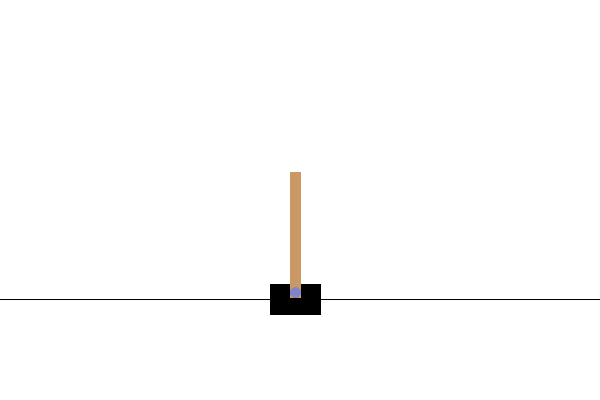

In [17]:
reward_sum = 0
frames = []
obs, _ = env.reset() #reset the env to get initial state


done = False

while not done:
    frame = env.render()
    frames.append(Image.fromarray(frame))
    action, log_prob = select_action(policy_network, obs)
    obs, reward, terminated, truncated, _ = env.step(action)

    reward_sum += reward

    done = terminated or truncated

env.close()
print(reward_sum)
# Save to GIF
frames[0].save("cartpole.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)

# Display the GIF in notebook
from IPython.display import Image as IPyImage
IPyImage(filename="cartpole.gif")